 # Opis zadania
 W tym notatniku stworzymy system analityczno-raportowy, mający wspomagać przyszłe decyzje biznesowe. Dzięki przeprowadzonej wcześniej analizie eksploracyjnej danych, w trakcie spotkania prezentującego wykonaną pracę postanowiono w pierwszym kroku stworzyć następujące wizualizacje danych:
 - Wyświetlenie TOP 10 tras samolotów pod względem najniższego odsetka opóźnień w formie tabeli,
 - Wyświetlenie porównania roku 2019 oraz 2020 w formie wykresu słupkowego:
     - miesiąc do miesiąca,
     - dzień tygodnia do dnia tygodnia,
 - Wyświetlenie danych dzień po dniu w formie szeregu czasowego.

Raport powinien składać się z trzech stron - `TOP report`, `Comparision` i `Day by day reliability`.

Pracując na podstawie wcześniej zdefiniowanych widoków, nie musimy się tutaj martwić o przetwarzanie oraz procesowanie danych. Co więcej, wszystkie niuanse techniczne w postaci liczby wierszy, wykonywanych złączeń, filtracji są przeniesione na bazę danych. Z technicznego punktu widzenia, pomiędzy serwisem a bazą danych dochodzi do przesyłania mniejszej ilości danych.

Dopuszczamy jednak pewne aktualizacje co do ich struktury przykładowo poprzez _pivotowanie_, czyli obranie i doprowadzanie do postaci tej znanej z tabel przestawnych.

> **Uwaga:**  
> Przy pracy nad poprawkami w dashboardzie, pamiętaj, że aby odświeżyć stronę po wprowadzonych zmianach, należy **całość** uruchomić ponownie.

 Tutaj zaimportuj potrzebne biblioteki

In [1]:
import psycopg2
from psycopg2 import connect
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import dash
from dash import dash_table
from dash.dependencies import Input, Output, State
import plotly.express as px
import threading
from dash import dcc
from dash import html

 ## Konfiguracja połączenia
 Tutaj uzupełnij konfigurację połączenia

In [2]:
connection = psycopg2.connect(
             host='localhost',
             user='postgres_user', 
             password='coderslab',
             dbname='airlines'  
             )

 Tutaj zdefiniuj zmienną `con` oraz `cursor`

In [3]:
con = connect(host='localhost', database='airlines', user='postgres_user', password='coderslab')
cursor = con.cursor()

 # Stworzenie tabeli dla `TOP 10 routes`
 W tym miejscu przygotujemy tabelkę oraz komponent, który zostanie następnie umieszczony w raporcie. Tabela powinna się składać z następujących kolumn:
 - Origin,
 - Destination,
 - Year,
 - Reliability,
 - Rank.

Wartości procentowe zaś powinny być postaci np. 13.87%.

Z tego względu konieczna będzie zmiana nazw kolumn dla wyników raportowania.

Wskazówki:
 - `Python - analiza danych > Dzień 5 - Pandas > Obróbka danych - część 2 > apply`,
 - [How to format percentage in python](https://stackoverflow.com/questions/5306756/how-to-print-a-percentage-value-in-python).

 Tutaj zaczytaj dane do ramki danych `top_routes_df` z widoku `reporting.top_reliability_roads`
 > Jeśli pojawi się komunikat `UserWarning: pandas only support SQLAlchemy`, z naszego punktu widzenia, możemy go śmiało zignorować.

In [4]:
query = "SELECT origin_airport_name AS Origin, dest_airport_name AS Destination, year AS Year, reliability AS Reliability, nb AS Rank FROM reporting.top_reliability_roads ORDER BY nb LIMIT 10"
cursor.execute(query)
top_routes_data = cursor.fetchall()
columns = [desc[0] for desc in cursor.description]
top_routes_df = pd.DataFrame(top_routes_data, columns=columns)

 Tutaj dokonaj aktualizacji formatu liczbowego dla kolumny `reliability`

In [5]:
top_routes_df['reliability'] = top_routes_df['reliability'].apply(lambda x: '{:.2%}'.format(x / 100))

In [6]:
# top_routes_df['reliability'] = top_routes_df['reliability'].map("{:.2%}".format)

 Tutaj odpowiednio dokonaj zmian nazewnictwa kolumn

In [7]:
top_routes_df = top_routes_df.rename(columns={'Origin': 'Origin Airport', 'Destination': 'Destination Airport'})

In [8]:
top_routes_df

,origin,destination,year,reliability,rank


 # Porównanie rok do roku (YoY) 2019 vs. 2020
 W tym miejscu stworzymy wykres oraz komponent, który zostanie następnie umieszczony w raporcie. Wykres powinien przedstawiać porównanie lat 2019 oraz 2020 po miesiącach względem zmiennej `reliability`.

 > Na wykresie chcemy również przedstawić dane, które nie mają porównania tj. od kwietnia do grudnia 2019.

W tym celu wykonamy poniższe zadania:
 - Przekształcimy tabelkę do formy tabeli przestawnej
 - Stworzymy wykres słupkowy porównujący dane rok do roku
 - Opakujemy stworzony wykres w komponent `Dash`

Wskazówki:
 - `Wizualizacja danych > Dzień 3 > Dash`,
 - `Wizualizacja danych > Dzień 1 > Budowanie wykresów plotly`,
 - `Python - analiza danych > Dzień 6 - Pandas c.d > Pivot`.

 Tutaj pobierz z widoku `reporting.year_to_year_comparision` dane do ramki `yoy_comparision_df`

In [11]:
query = "SELECT * FROM reporting.year_to_year_comparision"
cursor.execute(query)
yoy_comparision_data = cursor.fetchall()
columns = [desc[0] for desc in cursor.description]
yoy_comparision_df = pd.DataFrame(yoy_comparision_data, columns=columns)

 Tutaj odpowiednio przekształć ramkę - do formy oczekiwanej przez wykres słupkowy. Wyniki zapisz do zmiennej `yoy_comparision_to_plot_df`

In [12]:
yoy_comparision_df['reliability'] = yoy_comparision_df['reliability'].astype(float)

In [13]:
yoy_comparision_to_plot_df = yoy_comparision_df.pivot(index='month', columns='year', values='reliability')

 Tutaj stwórz odpowiedni wykres, zapisz do na później pod nazwą `yoy_comparision_fig`. Pamiętaj o dobrych praktykach - niech wykres posiada wszystkie opisy oraz opisowe etykiety osi.

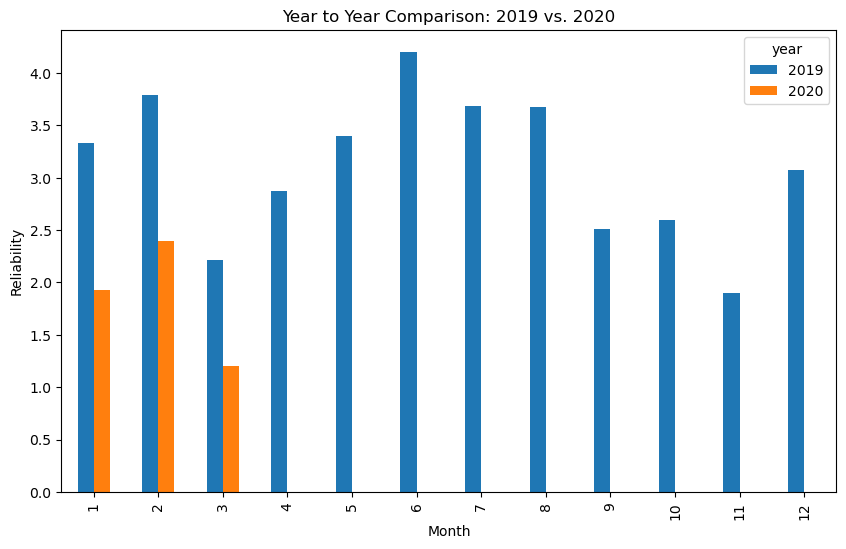

In [14]:
yoy_comparision_fig = yoy_comparision_to_plot_df.plot(kind='bar', figsize=(10, 6))
yoy_comparision_fig.set_xlabel('Month')
yoy_comparision_fig.set_ylabel('Reliability')
yoy_comparision_fig.set_title('Year to Year Comparison: 2019 vs. 2020')
plt.show()

 # Porównanie dzień tygodnia do dnia tygodnia (WKoWK) 2019 vs. 2020
 Wykonaj analogiczne do poprzedniego kroku, używając jednak w tym momencie danych z widoku `reporting.day_to_day_comparision`

 Tutaj pobierz z widoku `reporting.day_to_day_comparision` dane do ramki `day_to_day_comparision_df`

In [15]:
query = "SELECT * FROM reporting.day_to_day_comparision"
cursor.execute(query)
day_to_day_comparision_data = cursor.fetchall()
columns = [desc[0] for desc in cursor.description]
day_to_day_comparision_df = pd.DataFrame(day_to_day_comparision_data, columns=columns)

 Tutaj odpowiednio przekształć ramkę - do formy oczekiwanej przez wykres słupkowy. Wyniki zapisz do zmiennej `day_to_day_comparision_to_plot_df`

In [16]:
day_to_day_comparision_to_plot_df = day_to_day_comparision_df.pivot(index='day_of_week', columns='year', values='flights_amount')

 Tutaj stwórz odpowiedni wykres, zapisz go na później pod nazwą `day_to_day_comparision_fig`. Pamiętaj o dobrych praktykach - niech wykres posiada wszystkie opisy oraz opisowe etykiety osi.

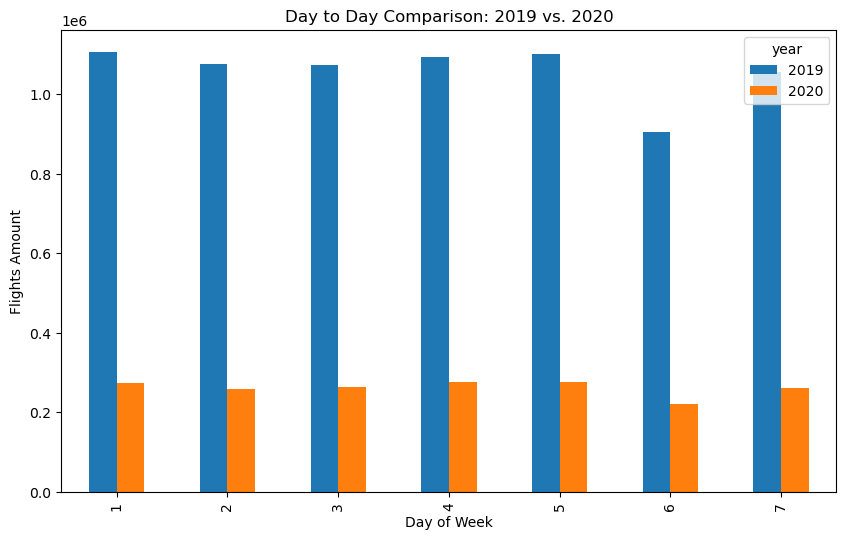

In [17]:
day_to_day_comparision_fig = day_to_day_comparision_to_plot_df.plot(kind='bar', figsize=(10, 6))
day_to_day_comparision_fig.set_xlabel('Day of Week')
day_to_day_comparision_fig.set_ylabel('Flights Amount')
day_to_day_comparision_fig.set_title('Day to Day Comparison: 2019 vs. 2020')
plt.show()

 # Stworzenie szeregu czasowego
 W tym miejscu stworzymy wykres w formie szeregu czasowego, który zostanie umieszcony w raporcie. Wykres powinien przedstawiać dane w formie szeregu czasowego (dzień po dniu) dla lat 2019 oraz 2020. Dla możliwości identyfikacji poszczególnych lat, zostaliśmy dodatkowo poproszeni o nadanie innego koloru dla roku 2019 oraz 2020.

 > Pamiętaj o stworzeniu wykresu zgodnie z dobrymi praktykami.

 W tym miejscu pobierz dane do ramki `day_by_day_reliability_df`, z widoku `reporting.day_by_day_reliability`.

In [18]:
query = "SELECT * FROM reporting.day_by_day_reliability"
cursor.execute(query)
day_by_day_reliability_data = cursor.fetchall()
columns = [desc[0] for desc in cursor.description]
day_by_day_reliability_df = pd.DataFrame(day_by_day_reliability_data, columns=columns)

 Tutaj stwórz wykres liniowy na podstawie pobranych danych. Wynik zapisz do zmiennej `day_by_day_reliability_fig`.

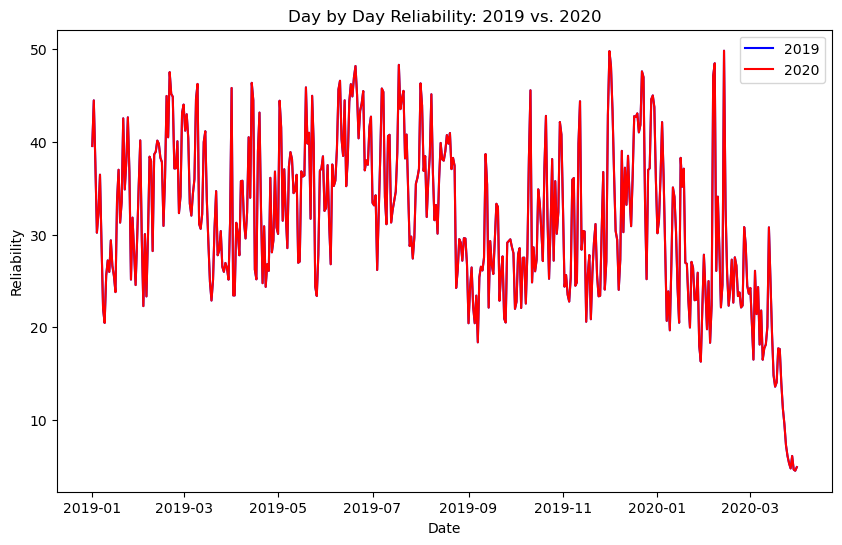

In [19]:
day_by_day_reliability_fig = plt.figure(figsize=(10, 6))
plt.plot(day_by_day_reliability_df['date'], day_by_day_reliability_df['reliability'], color='blue', label='2019')
plt.plot(day_by_day_reliability_df['date'], day_by_day_reliability_df['reliability'], color='red', label='2020')
plt.xlabel('Date')
plt.ylabel('Reliability')
plt.title('Day by Day Reliability: 2019 vs. 2020')
plt.legend()
plt.show()

 # Stworzenie layoutów poszczególnych stron

 ## Stworzenie layout dla widoku `TOP 10 routes`
 W tym momencie przekonwertujemy zmienną `top_routes_df` w postać `Dash.DataTable`. Dodatkowo, dla czytelności, dodamy nagłówek opisujący co tabela przedstawia.

 Nagłówek wystylizuj używając poniższych wymagań:
 - tag: `H3`,
 - czcionka: `verdana`,
 - kolor: '#4444`,
 - tekst do wyświetlenia: `TOP 10 reliability routes in 2019 and 2020`

Wskazówki:
 - `Wizualizacja danych > Dzień 3 > Dash`,
 - `Wizualizacja danych > Dzień 3 > Dash - datatable`,
 - Dokmentacja metody `Pandas` - [to_dict](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_dict.html).

 Tutaj przygotuj komponent `Dash` `DataTable`, zapisując wynik do zmiennej `top_routes_table`

In [20]:
top_routes_table = dash_table.DataTable(
    id='top-routes-table',
    columns=[{"name": i, "id": i} for i in top_routes_df.columns],
    data=top_routes_df.to_dict('records'),
)

 Tutaj przygotuj nagłówek dla tabeli, zapisz go pod nazwą `top_routes_page_title`

In [21]:
top_routes_page_title = html.H3(
    "TOP 10 reliability routes in 2019 and 2020",
    style={"font-family": "verdana", "color": "#444444"}
)

 Tutaj przygotuj layout dla widoku `TOP 10 routes`. Konfigurację zapisz do zmiennej `top_routes_layout`

In [22]:
top_routes_layout = html.Div(children=[
    top_routes_page_title,
    top_routes_table
])

 ## Stworzenie layout dla widoku `Comparision`
 W tym momencie opakujemy zmienne `yoy_comparision_fig` oraz `day_to_day_comparision_fig` do komponentów `Dash`, a następnie stworzymy odpowiedni `layout` dla strony `comparision`. Wyniki zapiszemy do zmiennej `comparision_layout`.

 Tutaj opakuj `yoy_comparision_fig` w odpowiedni komponent `Dash`. Wynik zapisz do zmiennej `yoy_comparision_component`.

In [23]:
yoy_comparision_component = dcc.Graph(
    id='yoy-comparision-graph',
    figure=yoy_comparision_fig
)

 Tutaj opakuj `day_to_day_comparision_fig` w odpowiedni komponent `Dash`. Wynik zapisz do zmiennej `day_to_day_comparision_component`.

In [24]:
day_to_day_comparision_component = dcc.Graph(
    id='day-to-day-comparision-graph',
    figure=day_to_day_comparision_fig
)

 Tutaj stwórz odpowiedni `layout` dla widoku `comparision`. Wynik zapisz do zmiennej `comparision_layout`.

In [25]:
comparision_layout = html.Div(children=[
    html.H3("Year to Year Comparision"),
    yoy_comparision_component,
    html.H3("Day to Day Comparision"),
    day_to_day_comparision_component
])

 Tutaj stwórz odpowiedni `layout` dla widoku `day by day`. Wynik zapisz do zmiennej `day_by_day_layout`.

In [26]:
day_by_day_layout = html.Div(children=[
    html.H3("Day by Day Reliability"),
    day_by_day_reliability_fig
])

 # Konfigurowanie aplikacji
 Posiadamy już wszystkie niezbędne komponenty do stworzenia oraz uruchomienia aplikacji. Naszym zadaniem w tym miejscu będzie odpowiednie jej skonfigurowanie, aby obsługiwała więcej niż jedną stronę.

 Chcemy, aby możliwe było poruszanie się pomiędzy poniższymi stronami:
 - `TOP report` - strona domyślna,
 - `Comparision` - strona dostępna pod adresem: `comparision_reporting`,
 - `Day by day reporting` - strona dostępna pod adresem: `day_by_day_reporting`

Wskazówki:
 - `Wizualizacja danych > Dzień 4 > Callback context`,
 - `Wizualizacja danych > Dzień 4 > Aplikacja multipage`.
 - Używając komponentu [html.Button](https://community.plotly.com/t/button-with-link/11809), możesz łatwo stworzyć bardziej wizualne linki do poszczególnych stron.

 Tutaj przygotuj layout aplikacji

In [27]:
app = dash.Dash(__name__)

app.layout = html.Div([
    dcc.Location(id='url', refresh=False),
    html.Button("Go to Comparision", id="btn-comparision", n_clicks=0),
    html.Button("Go to Day by Day Reporting", id="btn-day-by-day", n_clicks=0),
    html.Div(id='page-content')
])

 Tutaj stwórz procedurę odpowiadającą za nawigację pomiędzy poszczególnymi stronami

In [28]:
@app.callback(Output('url', 'pathname'),
              [Input('btn-comparision', 'n_clicks'),
               Input('btn-day-by-day', 'n_clicks')],
              [State('url', 'pathname')])
def update_url(btn_comparision_clicks, btn_day_by_day_clicks, current_path):
    ctx = dash.callback_context
    if not ctx.triggered:
        return current_path
    else:
        button_id = ctx.triggered[0]["prop_id"].split(".")[0]
        if button_id == "btn-comparision":
            return "/comparision_reporting"
        elif button_id == "btn-day-by-day":
            return "/day_by_day_reporting"
        else:
            return current_path

In [29]:
@app.callback(Output('page-content', 'children'),
              [Input('url', 'pathname')])
def display_page(pathname):
    if pathname == '/':
        return top_routes_layout
    elif pathname == '/comparision_reporting':
        return comparision_layout
    elif pathname == '/day_by_day_reporting':
        return day_by_day_layout
    else:
        return '404 Page not found'

 Tutaj uruchom aplikację

In [32]:
if __name__ == '__main__':
    app.run_server(debug=False)

[2024-11-27 15:29:24,741] ERROR in app: Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/Users/me/miniconda3/lib/python3.12/site-packages/dash/_callback.py", line 483, in add_context
    jsonResponse = to_json(response)
                   ^^^^^^^^^^^^^^^^^
  File "/Users/me/miniconda3/lib/python3.12/site-packages/dash/_utils.py", line 26, in to_json
    return to_json_plotly(value)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/Users/me/miniconda3/lib/python3.12/site-packages/plotly/io/_json.py", line 142, in to_json_plotly
    json.dumps(plotly_object, cls=PlotlyJSONEncoder, **opts), _swap_json
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/me/miniconda3/lib/python3.12/json/__init__.py", line 238, in dumps
    **kw).encode(obj)
          ^^^^^^^^^^^
  File "/Users/me/miniconda3/lib/python3.12/site-packages/_plotly_utils/utils.py", line 56, in encode
    encoded_o = super(PlotlyJSONEncoder, self).encode(o)
                ^

 # Podsumowanie
 W tym notatniku stworzyliśmy zgodnie z wymaganiami raport do dyspozycji osób decyzyjnych. Kod źródłowy może w tym momencie zostać przekazany dalej, do działu IT, który następnie wdroży rozwiązanie na serwer dostępny dla każdej zainteresowanej osoby. W praktyce oznacza to koniec naszej pracy nad tym zadaniem. Choć warto dodać, że często po udostępnieniu raportu pojawiają się dodatkowe wymagania oraz komentarze ze względu na informacje, które są tam zawarte.

 W kolejnym notatniku podsumujemy sobie cały warsztat.